In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn

## Imports
import os
import sys
import matplotlib.pyplot as plt
import pickle

In [3]:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "./"))

if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.utils.logger import Logging
from src.poisson.dv_solver import DVPDESolver
from src.poisson.cv_solver import CVPDESolver
from src.nn.pde import wave_operator
from src.utils.plot_prediction import plt_prediction
from src.data.klein_gordon_dataset import u, f
import src.poisson.klein_gordon_train as klein_gordon_train
from src.poisson.classical_solver import Classical_Solver
from src.data.klein_gordon_dataset import Sampler

from src.nn.pde import klein_gordon_operator

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'    # for no GPUs


## Gates supported by strawberryfields.fock


In [4]:
DEVICE = 'cpu'


In [5]:

mode = "hybrid"
num_qubits = 5
output_dim = 1
input_dim = 2
hidden_dim = 50
num_quantum_layers = 1
cutoff_dim = 10
classic_network = [input_dim, hidden_dim, output_dim]



args = {
    "batch_size": 64,
    "epochs": 20000,
    "lr": 0.0001,
    "seed": 1,
    "print_every": 1000,
    "log_path": "./checkpoints/helmholtz",
    "input_dim": input_dim,
    "output_dim": output_dim,
    "num_qubits": num_qubits,
    "hidden_dim": hidden_dim,
    "num_quantum_layers": num_quantum_layers,
    "classic_network": classic_network,
    "q_ansatz": "sim_circ_19",  # options: "alternating_layer_tdcnot", "abbas" , farhi , sim_circ_13_half, sim_circ_13 , sim_circ_14_half, sim_circ_14 , sim_circ_15 ,sim_circ_19
    "mode": mode,
    "activation": "tanh",  # options: "null", "partial_measurement_half" , partial_measurement_x
    "shots": None,  # Analytical gradients enabled
    "problem": "helmholtz",
    "solver": "DV",  # options : "CV", "Classical", "DV"
    "device": DEVICE,
    "method": "None",
    "cutoff_dim": cutoff_dim,  # num_qubits >= cutoff_dim
    "class": "DV",  # options : "DVQuantumLayer", GSRandomCVQNN , "CVQuantumLayer", "Enhanced_CVQuantumLayer"
    "encoding": "angle", # options angle , amplitude
}


In [6]:
log_path = args["log_path"]
logger = Logging(log_path)

In [7]:

if args["solver"] == "CV":
    model = CVPDESolver(args, logger, DEVICE)
    model.logger.print("Using CV Solver")
elif args["solver"] == "Classical":
    model = Classical_Solver(args, logger, DEVICE)
    model.logger.print("Using Classical Solver")
else:
    model = DVPDESolver(args, logger, DEVICE)
    model.logger.print("Using DV Solver")
# Training loop
model.logger.print(f"The settings used:")
for key, value in args.items():
    model.logger.print(f"{key} : {value}")


# Print total number of parameters
total_params = sum(p.numel() for p in model.parameters())
model.logger.print(f"Total number of parameters: {total_params}")


INFO:src.utils.logger:Using DV Solver
INFO:src.utils.logger:The settings used:
INFO:src.utils.logger:batch_size : 64
INFO:src.utils.logger:epochs : 20000
INFO:src.utils.logger:lr : 0.0001
INFO:src.utils.logger:seed : 1
INFO:src.utils.logger:print_every : 1000
INFO:src.utils.logger:log_path : ./checkpoints/helmholtz
INFO:src.utils.logger:input_dim : 2
INFO:src.utils.logger:output_dim : 1
INFO:src.utils.logger:num_qubits : 5
INFO:src.utils.logger:hidden_dim : 50
INFO:src.utils.logger:num_quantum_layers : 1
INFO:src.utils.logger:classic_network : [2, 50, 1]
INFO:src.utils.logger:q_ansatz : sim_circ_19
INFO:src.utils.logger:mode : hybrid
INFO:src.utils.logger:activation : tanh
INFO:src.utils.logger:shots : None
INFO:src.utils.logger:problem : helmholtz
INFO:src.utils.logger:solver : DV
INFO:src.utils.logger:device : cpu
INFO:src.utils.logger:method : None
INFO:src.utils.logger:cutoff_dim : 10
INFO:src.utils.logger:class : DV
INFO:src.utils.logger:encoding : angle
INFO:src.utils.logger:Tota

In [ ]:
klein_gordon_train.train(model)
model.save_state()


INFO:src.utils.logger:The circuit used in the study:


The circuit is saved in ./checkpoints/helmholtz/2025-02-20_19-25-19-820007


INFO:src.utils.logger:It: 0, Loss: 1.137e+03, Loss_res: 1.125e+04,  Loss_bcs: 1.161e+00, Loss_ut_ics: 3.383e-06, lr: 5.000e-03, Time: 6.99
INFO:src.utils.logger:Model state saved to ./checkpoints/helmholtz/2025-02-20_19-25-19-820007/model.pth
INFO:src.utils.logger:It: 1000, Loss: 2.265e+00, Loss_res: 2.163e+01,  Loss_bcs: 6.485e-03, Loss_ut_ics: 3.688e-01, lr: 5.000e-03, Time: 14772.35
INFO:src.utils.logger:Model state saved to ./checkpoints/helmholtz/2025-02-20_19-25-19-820007/model.pth
INFO:src.utils.logger:It: 2000, Loss: 3.161e+00, Loss_res: 3.123e+01,  Loss_bcs: 1.852e-03, Loss_ut_ics: 1.999e-01, lr: 4.500e-03, Time: 47149.35
INFO:src.utils.logger:Model state saved to ./checkpoints/helmholtz/2025-02-20_19-25-19-820007/model.pth


## Plot loss history

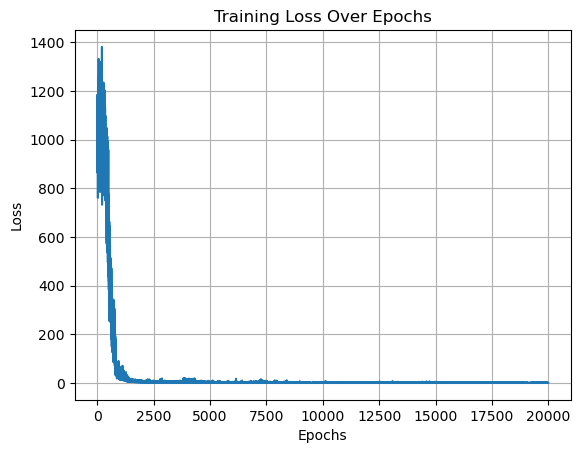

In [ ]:
plt.plot(range(len(model.loss_history)), model.loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid()

file_path = os.path.join(model.log_path, "loss_history.pdf")
plt.savefig(file_path, bbox_inches="tight")
plt.show()

plt.close(
    "all",
)

# Testing


In [ ]:
# Parameters of equations
alpha = torch.tensor(-1.0, device=DEVICE)
beta = torch.tensor(0.0, device=DEVICE)
gamma = torch.tensor(1.0, device=DEVICE)
k = 3
dom_coords = np.array([[0.0, 0.0], [1.0, 1.0]], dtype=np.float32)


# Create mesh grid with float32
nn = 200
t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn, dtype=np.float32)[:, None]
x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn, dtype=np.float32)[:, None]
t, x = np.meshgrid(t, x)

# Convert to PyTorch tensor with float32
X_star = torch.hstack((
    torch.from_numpy(t.flatten()[:, None]), 
    torch.from_numpy(x.flatten()[:, None])
)).to(DEVICE).to(torch.float32)

u_star = u(X_star)
f_star = f(X_star, alpha, beta, gamma, k)

In [ ]:
# Predictions


u_pred_star, f_pred_star = klein_gordon_operator(model, X_star[:, 0:1], X_star[:, 1:2])

u_pred = u_pred_star.cpu().detach().numpy()
f_pred = f_pred_star.cpu().detach().numpy()
u_star = u_star.cpu().detach().numpy()
f_star = f_star.cpu().detach().numpy()
X = X_star.cpu().detach().numpy()



INFO:src.utils.logger:Relative L2 error_u: 1.37e+01
INFO:src.utils.logger:Relative L2 error_f: 3.67e+00


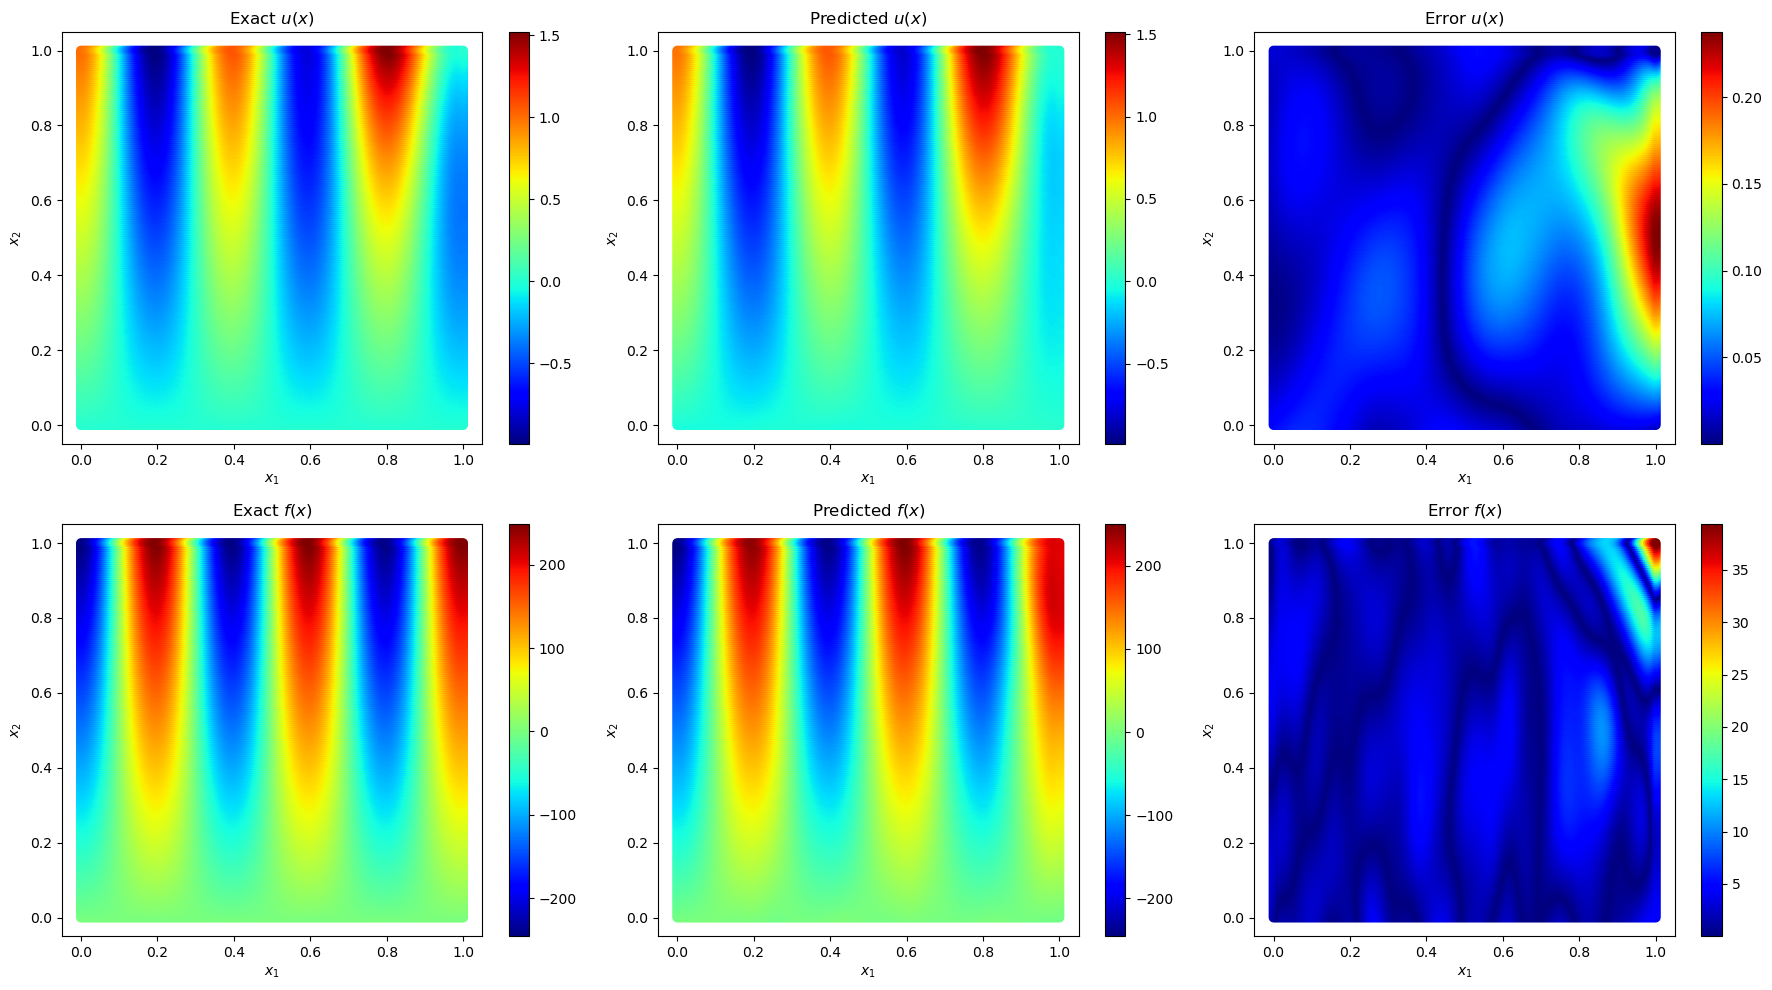

In [ ]:
# Relative L2 error
error_u = np.linalg.norm(u_pred - u_star) / np.linalg.norm(u_star) * 100
error_f = np.linalg.norm(f_pred - f_star) / np.linalg.norm(f_star) * 100
logger.print("Relative L2 error_u: {:.2e}".format(error_u))
logger.print("Relative L2 error_f: {:.2e}".format(error_f))


# Plot predictions
plt_prediction(
    logger,
    X,
    u_star,
    u_pred,
    f_star,
    f_pred,
)
